In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from classy import Class
from anilos import *
import matplotlib
import matplotlib.pyplot as plt
cmap = matplotlib.colormaps.get_cmap("jet")
import healpy as hp
from healpy.newvisufunc import projview

In [2]:
def alm_healpy(alm_array_list, mode):
    """ Sets the alms in the format expected by healpy
    
    Normalize the alms such that the numerical values are
    the coefficients of the expansion in the spherical
    harmonics. 
    
    Parameters
    ----------
    alm_array_list : list of arrays
        alm arrays in the total angular momentum basis
    mode : 't' or 'v'
        perturbation mode
    
    Returns 
    -------
    alms in the format expected by healpy
    
    Notes
    -----
    AniCLASS computes the alms in the total angular 
    momentum basis. This function performs the
    transformation to the usual spherical harmonics basis
    """
    
    ell_max = alm_array_list[0].size + 1
    if mode == 't':
        inter = [2 * ell_max + 1,3 * ell_max]
    elif mode == 'v':
        inter = [ell_max + 2,2 * ell_max + 1]
    else:
        raise ValueError("mode not defined")
        
    len_alm = sum([l+1 for l in range(ell_max+1)])  # a_{l,-m} = (-1)^m a*_{lm}
    row = [0 for _ in range(ell_max - 1)]
    col = [i for i in range(inter[0],inter[1])]
    output_list = []
    for i, alm_array in enumerate (alm_array_list):
        normalization = [(1j)**l*np.sqrt(4*np.pi /(2*l+1))  for l in range (2, ell_max + 1)]
        alm_sph = normalization * alm_array
        alm = coo_matrix((alm_sph,
                            (row,col)
                            ),
                            shape=(1,len_alm),
                            dtype='complex'
                            )
        alm = np.array(alm.todense())[0]
        output_list.append(alm)   
    return output_list

list_label = ["T_tensor", "T_vector",
              "E_tensor", "E_vector",
              "B_tensor", "B_vector"
             ]

# Quickstart example

In [3]:
cosmo = Class() # Instance of Class
# Required parameters
params = {'hierarchy': 'tam', # Total angular momentum method
          'radiation_streaming_approximation': 3,
          'statistics': 'non_stochastic', 
          'non_stochastic_type': 'bianchi', # Calculations are performed in the context of Bianchi
          'output': 'tCl pCl', # output: temperature and polarization
          'modes': 't v',
          'k_output_values': '0.002', # Perturbation scale
          'l_max_tensors': 1000, # Maximum value that is computed by the integrator
          'l_max_vectors': 1000
         }
cosmo.set(params) # Set the parameters
cosmo.compute(['bianchi']) # Compute alms
# Store them
alm_tensor = cosmo.alm_bianchi(1000)['k_0']['t'] 
alm_vector = cosmo.alm_bianchi(1000)['k_0']['v']
cosmo.struct_cleanup() # Do not forget to kill Class

In [4]:
# Structure of the dictionary
almT_tensor = alm_tensor['T']
almE_tensor = alm_tensor['E']
almB_tensor = alm_tensor['B']

almT_vector = alm_vector['T']
almE_vector = alm_vector['E']
almB_vector = alm_vector['B']

In [5]:
# Both vector and tensor arrays start at the dipole
print(almT_tensor.size)
print(almT_vector.size)

999
999


## Plotting the maps

In [6]:
# Set the alms in the format expected by healpy 
# see healpy.sphtfunc.alm2map docstring

alm_list_tensor = [almT_tensor, almE_tensor, almB_tensor]
alm_list_vector = [almT_vector, almE_vector, almB_vector]

almT_tensor_sph, almE_tensor_sph, almB_tensor_sph = alm_healpy(alm_list_tensor, 't')
almT_vector_sph, almE_vector_sph, almB_vector_sph = alm_healpy(alm_list_vector, 'v')

alms_list = [almT_tensor_sph, almT_vector_sph,
             almE_tensor_sph, almE_vector_sph,
             almB_tensor_sph, almB_vector_sph
            ]

In [7]:
# Create the maps
nside = 2 ** 7
maps_list = []
for i in range (6):
    map_from_alm = hp.sphtfunc.alm2map(alms_list[i], nside)
    maps_list.append(map_from_alm)

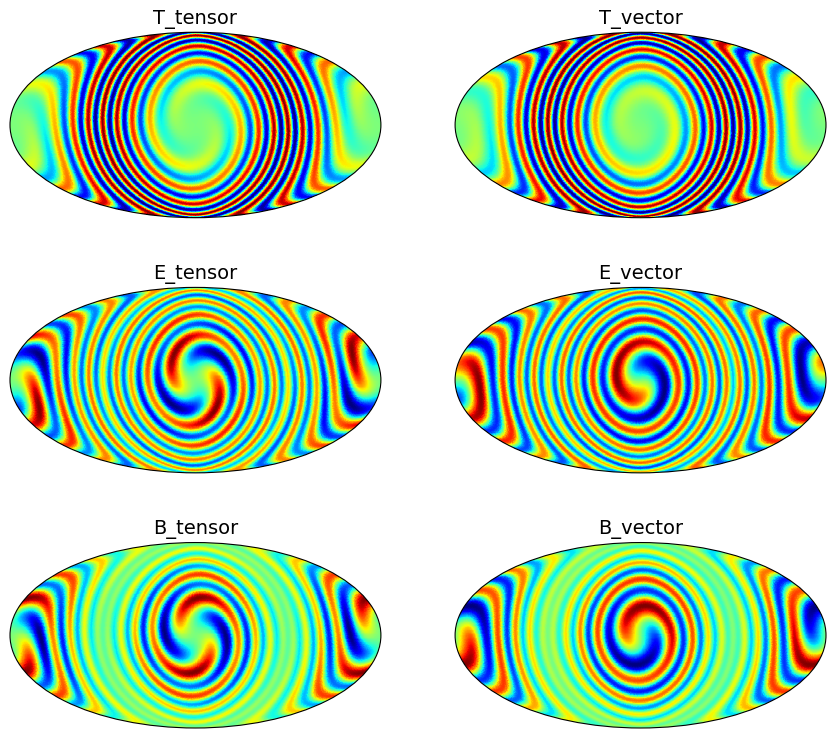

In [8]:
j = 0
for _ in range (3):
    for _ in range (2):
        projview(
                maps_list[j],
                projection_type="mollweide",
                cmap = cmap,
                rot = (0, 90, 0),
                sub = (3,2, j+1),
                cbar = False,
                title = list_label[j]
                )
        j+=1

# Changing parameters

See explanatory.ini for definitions.

See also Bianchi.ini for definitions related to Bianchi

Note that some parameters do not affect the calculations in the context of Bianchi cosmologies

Also note that CLASS does not compute Omega_K from Omega_m and Omega_Lambda, so always remember to inform Omega_k if you do not want the default value

In [9]:
cosmo = Class()
params = {'h' : 0.72, # Dimensionless hubble constant
          # 'Omega_b' : 0.04, # Baryon density parameter today
          # 'Omega_cdm' : 0.2, # CDM density parameter today
          # 'Omega_m' : 0.24, # Matter density parameter today
          # 'Omega_Lambda' : 0.76, # Dark energy density parameter today
          'Omega_k' : 1e-5, # Always remember to inform Omega_k if you don't want the default value
          'hierarchy': 'tam',
          'radiation_streaming_approximation': 3,
          'statistics': 'non_stochastic',
          'non_stochastic_type': 'bianchi',
          'output': 'tCl pCl',
          'modes': 't v',
          'k_output_values': '2e-3',
          'l_max_tensors': 1000,
          'l_max_vectors': 1000,
          'z_reio' : 10,
          'ic_v' : 'oct', # Initial conditions for vector modes
                          # Default is isocurvature
          'gauge' : 'newtonian', # Gauge
                                # Default is synchronous
          # Precision related variables
          'tight_coupling_trigger_tau_c_over_tau_h':0.005,
          'tight_coupling_trigger_tau_c_over_tau_k' : 0.005,
          'start_sources_at_tau_c_over_tau_h' : 0.005,
          'perturbations_sampling_stepsize' : 0.01,
          'tol_perturbations_integration' : 1e-7,
          'hyper_x_min' : 1e-4,
          # Cutoff multipoles
          'l_max_g_vec': 30,
          'l_max_pol_g_vec': 30, 
          'l_max_ur_vec': 30,
          'l_max_g_ten': 30,
          'l_max_pol_g_ten': 30, 
          'l_max_ur_ten': 30
         }
cosmo.set(params)
cosmo.compute(['bianchi'])
alm_tensor = cosmo.alm_bianchi(1000)['k_0']['t'] 
alm_vector = cosmo.alm_bianchi(1000)['k_0']['v']
cosmo.struct_cleanup() 

In [10]:
almT_tensor = alm_tensor['T']
almE_tensor = alm_tensor['E']
almB_tensor = alm_tensor['B']
almT_vector = alm_vector['T']
almE_vector = alm_vector['E']
almB_vector = alm_vector['B']

alm_list_tensor = [almT_tensor, almE_tensor, almB_tensor]
alm_list_vector = [almT_vector, almE_vector, almB_vector]

almT_tensor_sph, almE_tensor_sph, almB_tensor_sph = alm_healpy(alm_list_tensor, 't')
almT_vector_sph, almE_vector_sph, almB_vector_sph = alm_healpy(alm_list_vector, 'v')

alms_list = [almT_tensor_sph, almT_vector_sph,
             almE_tensor_sph, almE_vector_sph,
             almB_tensor_sph, almB_vector_sph
            ]

In [11]:
# Create the maps
nside = 2 ** 7
maps_list = []
for i in range (6):
    map_from_alm = hp.sphtfunc.alm2map(alms_list[i], nside)
    maps_list.append(map_from_alm)

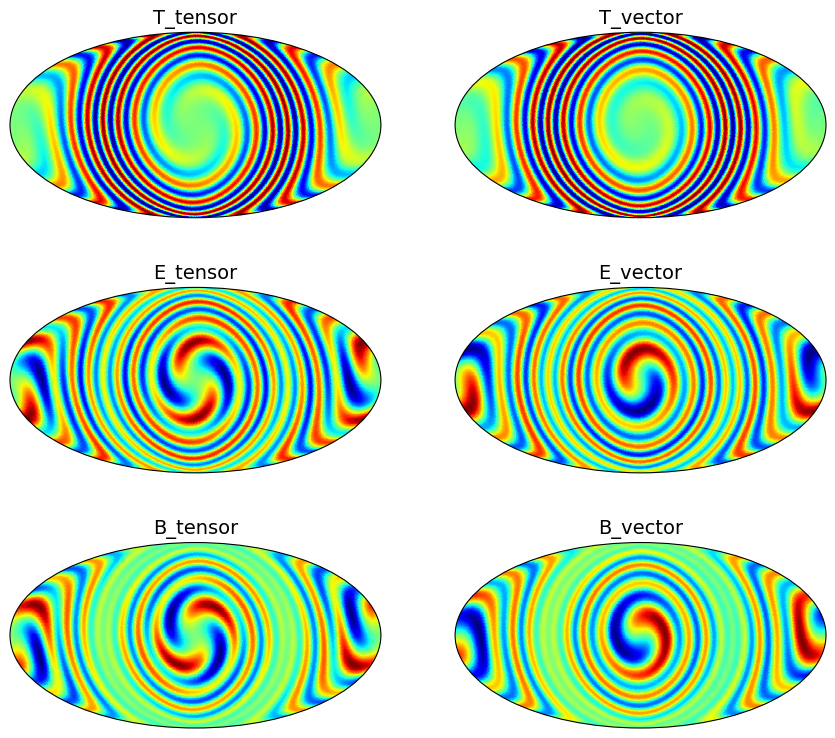

In [12]:
j = 0
for _ in range (3):
    for _ in range (2):
        projview(
                maps_list[j],
                projection_type="mollweide",
                cmap = cmap,
                rot = (0, 90, 0),
                sub = (3,2, j+1),
                cbar = False,
                title = list_label[j]
                )
        j+=1

# Choosing a Bianchi Model

Maps for each Bianchi model with isotropic limit can be computed setting combinations of $k$ (Fourier mode) and $\Omega_K$ (or values of the density parameters).

Due to the matching of perturbations, the Fourier modes are related to the spiraling lenght as $k = \frac{m}{\ell_s}$, where $m = 1, 2$ for vector and tensor perturbations respectively. The dimension of $k$ is Mpc$^{-1}$.

Bianchi VII$_0$ : finite $\ell_s$ and $\Omega_K = 10^{-6}$ (or combinations of $\Omega_m$ and $\Omega_\Lambda$ such that $\Omega_K$ is small);

Bianchi VII$_h$ : finite $\ell_s$ and positive $\Omega_K$;

Bianchi V : small values of $k$, around $10^{-8} \sim 10^{-10}$, and positive $\Omega_K$;

Bianchi IX : Negative $\Omega_K$.

## Bianchi VII$_0$

In [13]:
# Calculating the scale from the spiraling lenght
spiraling_length = 500 # Mpc
k_t = 2 / spiraling_length
k_v = 1 / spiraling_length
k_output_string = f'{k_t}, {k_v}'
print(k_output_string)

0.004, 0.002


In [14]:
cosmo = Class()
params = {'Omega_m' : 0.24,
          'Omega_Lambda' : 0.76,
          'hierarchy': 'tam', 
          'radiation_streaming_approximation': 3,
          'statistics': 'non_stochastic', 
          'non_stochastic_type': 'bianchi', 
          'output': 'tCl pCl',
          'modes': 't v',
          'ic_v' : 'oct',
          'k_output_values': k_output_string, 
          'l_max_tensors': 1000, 
          'l_max_vectors': 1000
         }
cosmo.set(params)
cosmo.compute(['bianchi'])
alm_tensor = cosmo.alm_bianchi(1000)['k_0']['t'] 
alm_vector = cosmo.alm_bianchi(1000)['k_1']['v']
cosmo.struct_cleanup()

In [15]:
almT_tensor = alm_tensor['T']
almE_tensor = alm_tensor['E']
almB_tensor = alm_tensor['B']
almT_vector = alm_vector['T']
almE_vector = alm_vector['E']
almB_vector = alm_vector['B']

alm_list_tensor = [almT_tensor, almE_tensor, almB_tensor]
alm_list_vector = [almT_vector, almE_vector, almB_vector]

almT_tensor_sph, almE_tensor_sph, almB_tensor_sph = alm_healpy(alm_list_tensor, 't')
almT_vector_sph, almE_vector_sph, almB_vector_sph = alm_healpy(alm_list_vector, 'v')

alms_list = [almT_tensor_sph, almT_vector_sph,
             almE_tensor_sph, almE_vector_sph,
             almB_tensor_sph, almB_vector_sph
            ]

In [16]:
# Create the maps
nside = 2 ** 7
maps_list = []
for i in range (6):
    map_from_alm = hp.sphtfunc.alm2map(alms_list[i], nside)
    maps_list.append(map_from_alm)

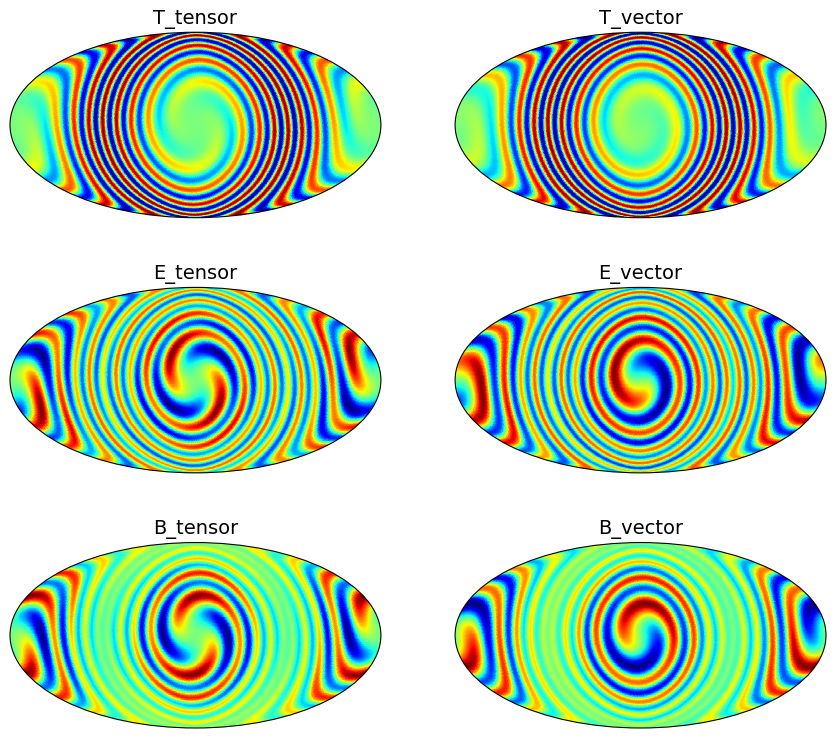

In [17]:
j = 0
for _ in range (3):
    for _ in range (2):
        projview(
                maps_list[j],
                projection_type="mollweide",
                cmap = cmap,
                rot = (0, 90, 0),
                sub = (3,2, j+1),
                cbar = False,
                title = list_label[j]
                )
        j+=1

## Bianchi VII$_h$

In [18]:
# Calculating the scale from the spiraling lenght
spiraling_length = 500 # Mpc
k_t = 2 / spiraling_length
k_v = 1 / spiraling_length
k_output_string = f'{k_t}, {k_v}'
print(k_output_string)

0.004, 0.002


In [19]:
cosmo = Class()
params = {'Omega_k' : 0.01,
          'hierarchy': 'tam', 
          'radiation_streaming_approximation': 3,
          'statistics': 'non_stochastic', 
          'non_stochastic_type': 'bianchi', 
          'output': 'tCl pCl',
          'modes': 't v',
          'gauge' : 'newtonian',
          'k_output_values': k_output_string, 
          'l_max_tensors': 1000, 
          'l_max_vectors': 1000
         }
cosmo.set(params)
cosmo.compute(['bianchi'])
alm_tensor = cosmo.alm_bianchi(1000)['k_0']['t'] 
alm_vector = cosmo.alm_bianchi(1000)['k_1']['v']
cosmo.struct_cleanup()

In [20]:
almT_tensor = alm_tensor['T']
almE_tensor = alm_tensor['E']
almB_tensor = alm_tensor['B']
almT_vector = alm_vector['T']
almE_vector = alm_vector['E']
almB_vector = alm_vector['B']

alm_list_tensor = [almT_tensor, almE_tensor, almB_tensor]
alm_list_vector = [almT_vector, almE_vector, almB_vector]

almT_tensor_sph, almE_tensor_sph, almB_tensor_sph = alm_healpy(alm_list_tensor, 't')
almT_vector_sph, almE_vector_sph, almB_vector_sph = alm_healpy(alm_list_vector, 'v')

alms_list = [almT_tensor_sph, almT_vector_sph,
             almE_tensor_sph, almE_vector_sph,
             almB_tensor_sph, almB_vector_sph
            ]

In [21]:
# Create the maps
nside = 2 ** 7
maps_list = []
for i in range (6):
    map_from_alm = hp.sphtfunc.alm2map(alms_list[i], nside)
    maps_list.append(map_from_alm)

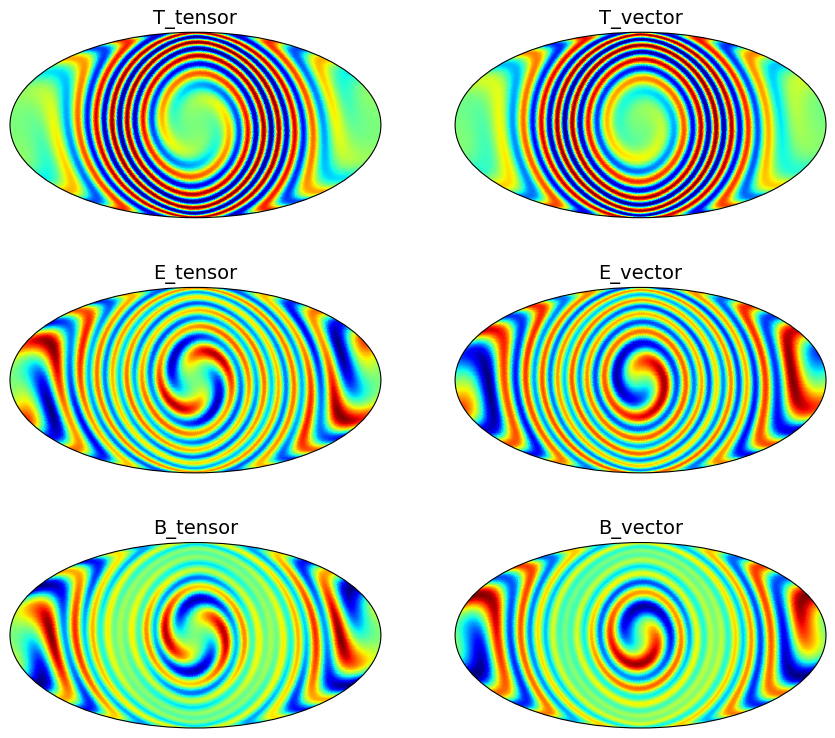

In [22]:
j = 0
for _ in range (3):
    for _ in range (2):
        projview(
                maps_list[j],
                projection_type="mollweide",
                cmap = cmap,
                rot = (0, 90, 0),
                sub = (3,2, j+1),
                cbar = False,
                title = list_label[j]
                )
        j+=1

## Bianchi V

In [23]:
# Calculating the scale from the spiraling lenght
spiraling_length = 4e8 # Mpc
k_t = 2 / spiraling_length
k_v = 1 / spiraling_length
k_output_string = f'{k_t}, {k_v}'
print(k_output_string)

5e-09, 2.5e-09


In [24]:
cosmo = Class()
params = {'Omega_k' : 0.01,
          'hierarchy': 'tam', 
          'radiation_streaming_approximation': 3,
          'statistics': 'non_stochastic', 
          'non_stochastic_type': 'bianchi', 
          'output': 'tCl pCl',
          'modes': 't v',
          'k_output_values': k_output_string, 
          'l_max_tensors': 1000, 
          'l_max_vectors': 1000
         }
cosmo.set(params)
cosmo.compute(['bianchi'])
alm_tensor = cosmo.alm_bianchi(1000)['k_0']['t'] 
alm_vector = cosmo.alm_bianchi(1000)['k_1']['v']
cosmo.struct_cleanup()

In [25]:
almT_tensor = alm_tensor['T']
almE_tensor = alm_tensor['E']
almB_tensor = alm_tensor['B']
almT_vector = alm_vector['T']
almE_vector = alm_vector['E']
almB_vector = alm_vector['B']

alm_list_tensor = [almT_tensor, almE_tensor, almB_tensor]
alm_list_vector = [almT_vector, almE_vector, almB_vector]

almT_tensor_sph, almE_tensor_sph, almB_tensor_sph = alm_healpy(alm_list_tensor, 't')
almT_vector_sph, almE_vector_sph, almB_vector_sph = alm_healpy(alm_list_vector, 'v')

alms_list = [almT_tensor_sph, almT_vector_sph,
             almE_tensor_sph, almE_vector_sph,
             almB_tensor_sph, almB_vector_sph
            ]

In [26]:
# Create the maps
nside = 2 ** 7
maps_list = []
for i in range (6):
    map_from_alm = hp.sphtfunc.alm2map(alms_list[i], nside)
    maps_list.append(map_from_alm)

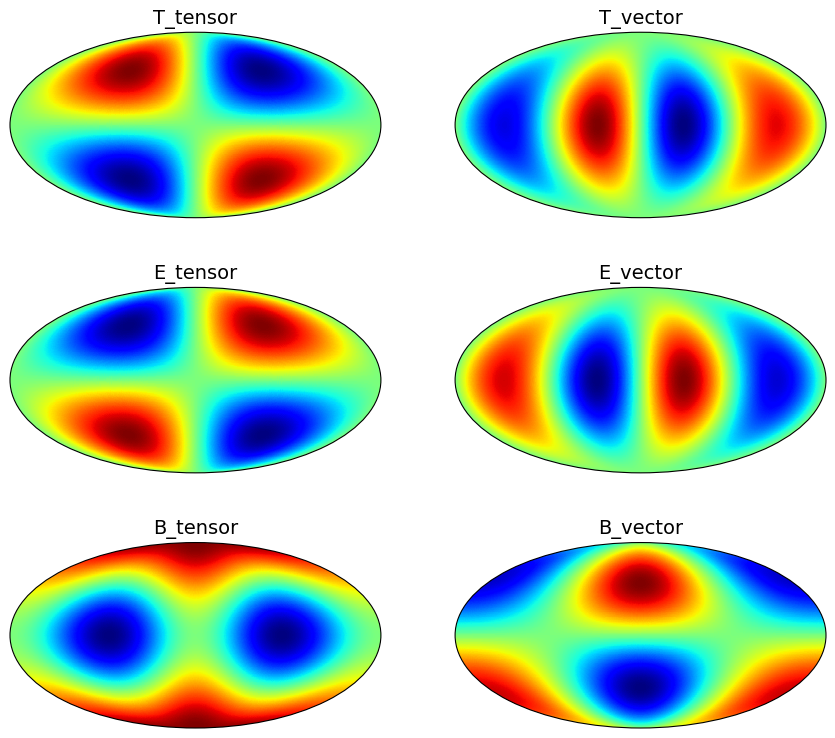

In [27]:
j = 0
for _ in range (3):
    for _ in range (2):
        projview(
                maps_list[j],
                projection_type="mollweide",
                cmap = cmap,
                rot = (0, 90, 0),
                sub = (3,2, j+1),
                cbar = False,
                title = list_label[j]
                )
        j+=1

## Bianchi IX

Bianchi IX is an special case where only the quadrupole of the tensor mode is non-zero

In [28]:
cosmo = Class()
params = {'Omega_k' : - 0.01,
          'hierarchy': 'tam', 
          'radiation_streaming_approximation': 3,
          'statistics': 'non_stochastic', 
          'non_stochastic_type': 'bianchi', 
          'output': 'tCl pCl',
          'modes': 't '
         }
cosmo.set(params)
cosmo.compute(['bianchi'])
alm_tensor = cosmo.alm_bianchi(2)['k_0']['t']
cosmo.struct_cleanup()

In [29]:
almT_tensor = alm_tensor['T']
almE_tensor = alm_tensor['E']
almB_tensor = alm_tensor['B']

alm_list_tensor = [almT_tensor, almE_tensor, almB_tensor]
almT_tensor_sph, almE_tensor_sph, almB_tensor_sph = alm_healpy(alm_list_tensor, 't')

alms_list = [almT_tensor_sph, almE_tensor_sph, almB_tensor_sph]

In [30]:
# Create the maps
nside = 2 ** 7
maps_list = []
for i in range (3):
    map_from_alm = hp.sphtfunc.alm2map(alms_list[i], nside)
    maps_list.append(map_from_alm)

In [31]:
list_label = ["T", "E", "B"]

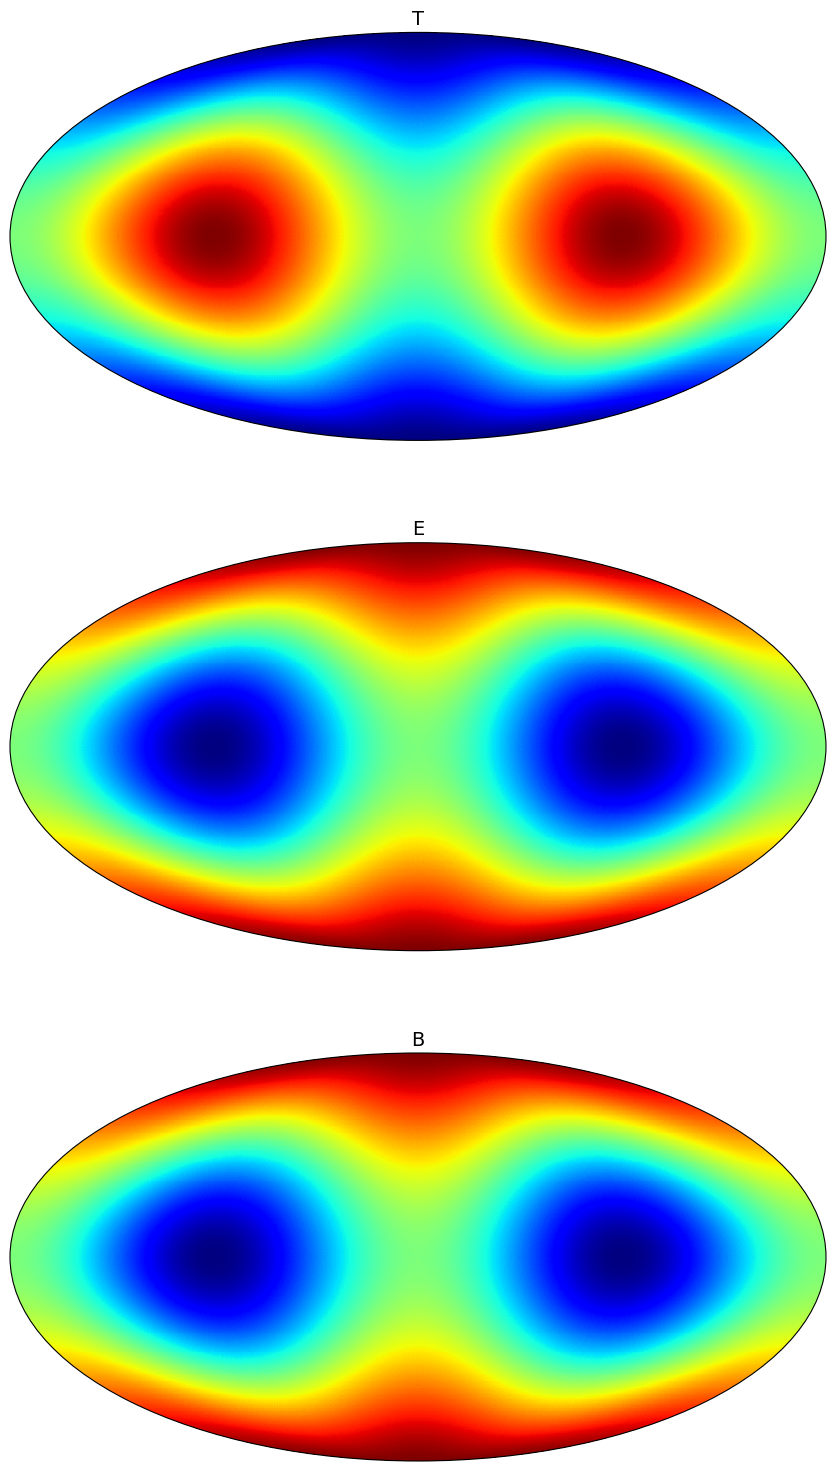

In [32]:
j = 0
for _ in range (3):
    projview(
            maps_list[j],
            projection_type="mollweide",
            cmap = cmap,
            rot = (0, 90, 0),
            sub = (3,1, j+1),
            cbar = False,
            title = list_label[j]
            )
    j+=1